<a href="https://colab.research.google.com/github/jw9603/CS224w_winter2021_assignment/blob/main/CS224W_Colab_3_jiwon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS224W - Colab 3**

In Colab 2 we constructed GNN models by using PyTorch Geometric built in GCN layer, the `GCNConv`. In this Colab we will implement the **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) and **GAT** ([Veličković et al. (2018)](https://arxiv.org/abs/1710.10903)) layers directly. Then we will run our models on the CORA dataset, which is a standard citation network benchmark dataset.

We will then use [DeepSNAP](https://snap.stanford.edu/deepsnap/), a Python library assisting efficient deep learning on graphs, to split the graphs in different settings and apply dataset transformations.

At last, using DeepSNAP transductive link prediction split functionality, we will construct a simple GNN model on the edge property predition (link prediction) task.

**Note**: Make sure to **sequentially run all the cells in each section**, so that the intermediate variables / packages will carry over to the next cell

Have fun on Colab 3 :)

# Device
You might need to use GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

## Installation

In [3]:
import torch
print(torch.__version__)


1.12.1+cu113


In [4]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
!pip install -q torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

     |████████████████████████████████| 7.9 MB 25.9 MB/s 
     |████████████████████████████████| 3.5 MB 31.7 MB/s 
     |████████████████████████████████| 407 kB 29.1 MB/s 


In [5]:
import torch_geometric
torch_geometric.__version__

'2.0.4'

# 1 GNN Layers

## Implementing Layer Modules

In colab 2, we implemented a network using GCN in node and graph classification tasks. However, the GCN module we used in colab 2 is from the official library. For this problem, we will provide you with a general Graph Neural Network Stack, where you'll be able to plugin your own modules of GraphSAGE and GATs. We will use our implementations to complete node classification on CORA, which is a standard citation network benchmark dataset. In this dataset, nodes correspond to documents and edges correspond to undirected citations. Each node has a class label. The node features are elements of a bag-or-words representation of a document. For the Cora dataset, there are 2708 nodes, 5429 edges, 7 prediction classes for nodes, and 1433 features per node. 

## GNN Stack Module

Below is the implementation for a general GNN Module that could plugin any layers, including **GraphSage**, **GAT**, etc. This module is provided for you, and you own **GraphSage** and **GAT** layers will function as components in the GNNStack Module.

In [6]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            # When applying GAT with num heads > 1, one needs to modify the 
            # input and output dimension of the conv layers (self.convs),
            # to ensure that the input dim of the next layer is num heads
            # multiplied by the output dim of the previous layer.
            # HINT: In case you want to play with multiheads, you need to change the for-loop when builds up self.convs to be
            # self.convs.append(conv_model(hidden_dim * num_heads, hidden_dim)), 
            # and also the first nn.Linear(hidden_dim * num_heads, hidden_dim) in post-message-passing.
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
          
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

## GraphSage Implementation

Now let's start working on our own implementation of layers! This part is to get you familiar with how to implement Pytorch layer based on Message Passing. You will be implementing the **forward**, **message** and **aggregate** functions.

Generally, the **forward** function is where the actual message passing is conducted. All logic in each iteration happens in **forward**, where we'll call **propagate** function to propagate information from neighbor nodes to central nodes.  So the general paradigm will be pre-processing -> propagate -> post-processing.

Recall the process of message passing we introduced in homework 1. **propagate** further calls **message** which transforms information of neighbor nodes into messages, **aggregate** which aggregates all messages from neighbor nodes into one, and **update** which further generates the embedding for nodes in the next iteration.

Our implementation is slightly variant from this, where we'll not explicitly implement **update**, but put the logic for updating nodes in **forward** function. To be more specific, after information is propagated, we can further conduct some operations on the output of **propagate**. The output of **forward** is exactly the embeddings after the current iteration.

In addition, tensors passed to **propagate()** can be mapped to the respective nodes $i$ and $j$ by appending _i or _j to the variable name, .e.g. x_i and x_j. Note that we generally refer to $i$ as the central nodes that aggregates information, and refer to $j$ as the neighboring nodes, since this is the most common notation.

Please find more details in the comments. One thing to note is that we're adding **skip connections** to our GraphSage. Formally, the update rule for our model is described as below:

\begin{equation}
h_v^{(l)} = W_l\cdot h_v^{(l-1)} + W_r \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

For simplicity, we use mean aggregations where:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

Additionally, $\ell$-2 normalization is applied after each iteration.

In order to complete the work correctly, we have to understand how the different functions interact with each other. In **propagate** we can pass in any parameters we want. For example, we pass in $x$ as an parameter:

... = propagate(..., $x$=($x_{central}$, $x_{neighbor}$), ...)

Here $x_{central}$ and $x_{neighbor}$ represent the features from **central** nodes and from **neighbor** nodes. If we're using the same representations from central and neighbor, then $x_{central}$ and $x_{neighbor}$ could be identical.

Suppose $x_{central}$ and $x_{neighbor}$ are both of shape N * d, where N is number of nodes, and d is dimension of features.

Then in message function, we can take parameters called $x\_i$ and $x\_j$. Usually $x\_i$ represents "central nodes", and $x\_j$ represents "neighbor nodes". Pay attention to the shape here: $x\_i$ and $x\_j$ are both of shape E(N x center노드개수) * d (**not N!**). $x\_i$ is obtained by concatenating the embeddings of central nodes of all edges through lookups from $x_{central}$ we passed in propagate. Similarly, $x\_j$ is obtained by concatenating the embeddings of neighbor nodes of all edges through lookups from $x_{neighbor}$ we passed in propagate.

Let's look at an example. Suppose we have 4 nodes, so $x_{central}$ and $x_{neighbor}$ are of shape 4 * d. We have two edges (1, 2) and (3, 0). Thus, $x\_i$ is obtained by $[x_{central}[1]^T; x_{central}[3]^T]^T$, and $x\_j$ is obtained by $[x_{neighbor}[2]^T; x_{neighbor}[0]^T]^T$

<font color='red'>For the following questions, DON'T refer to any existing implementations online.</font>

In [7]:
class GraphSage(MessagePassing):
    
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):  
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = None
        self.lin_r = None

        ############################################################################
        # TODO: Your code here! 
        # Define the layers needed for the message and update functions below.
        # self.lin_l is the linear transformation that you apply to embedding 
        #            for central node.
        # self.lin_r is the linear transformation that you apply to aggregated 
        #            message from neighbors.
        # Our implementation is ~2 lines, but don't worry if you deviate from this.]
        self.lin_l = nn.Linear(self.in_channels,self.out_channels)
        self.lin_r = nn.Linear(self.in_channels,self.out_channels)


        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        """"""

        out = None

        ############################################################################
        # TODO: Your code here! 
        # Implement message passing, as well as any post-processing (our update rule).
        # 1. First call propagate function to conduct the message passing.
        #    1.1 See there for more information: 
        #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        #    1.2 We use the same representations for central (x_central) and 
        #        neighbor (x_neighbor) nodes, which means you'll pass x=(x, x) 
        #        to propagate.
        # 2. Update our node embedding with skip connection.
        # 3. If normalize is set, do L-2 normalization (defined in 
        #    torch.nn.functional)
        # Our implementation is ~5 lines, but don't worry if you deviate from this.
        msg = self.propagate(edge_index,x=(x,x),size=size)
        out = self.lin_r(msg) + self.lin_l(x)
        if self.normalize:
            out = F.normalize(out,p=2)

        ############################################################################

        return out

    def message(self, x_j):

        out = None

        ############################################################################
        # TODO: Your code here! 
        # Implement your message function here.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        out = x_j

        ############################################################################

        return out

    def aggregate(self, inputs, index, dim_size = None):

        out = None

        # The axis along which to index number of nodes.
        node_dim = self.node_dim

        ############################################################################
        # TODO: Your code here! 
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: 
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        out = torch_scatter.scatter(inputs, index, node_dim, dim_size=dim_size, reduce='mean')
        ############################################################################

        return out


## GAT Implementation

Attention mechanisms have become the state-of-the-art in many sequence-based tasks such as machine translation and learning sentence representations. One of the major benefits of attention-based mechanisms is their ability to focus on the most relevant parts of the input to make decisions. In this problem, we will see how attention mechanisms can be used to perform node classification of graph-structured data through the usage of Graph Attention Networks (GATs).

The building block of the Graph Attention Network is the graph attention layer, which is a variant of the aggregation function . Let $N$ be the number of nodes and $F$ be the dimension of the feature vector for each node. The input to each graph attentional layer is a set of node features: $\mathbf{h} = \{\overrightarrow{h_1}, \overrightarrow{h_2}, \dots, \overrightarrow{h_N}$\}, $\overrightarrow{h_i} \in R^F$. The output of each graph attentional layer is a new set of node features, which may have a new dimension $F'$: $\mathbf{h'} = \{\overrightarrow{h_1'}, \overrightarrow{h_2'}, \dots, \overrightarrow{h_N'}\}$, with $\overrightarrow{h_i'} \in \mathbb{R}^{F'}$.

We will now describe this transformation of the input features into higher-level features performed by each graph attention layer. First, a shared linear transformation parametrized by the weight matrix $\mathbf{W} \in \mathbb{R}^{F' \times F}$ is applied to every node. Next, we perform self-attention on the nodes. We use a shared attentional mechanism:
\begin{equation} 
a : \mathbb{R}^{F'} \times \mathbb{R}^{F'} \rightarrow \mathbb{R}.
\end{equation}

This mechanism computes the attention coefficients that capture the importance of node $j$'s features to node $i$:
\begin{equation}
e_{ij} = a(\mathbf{W_l}\overrightarrow{h_i}, \mathbf{W_r} \overrightarrow{h_j})
\end{equation}
The most general formulation of self-attention allows every node to attend to all other nodes which drops all structural information. To utilize graph structure in the attention mechanisms, we can use masked attention. In masked attention, we only compute $e_{ij}$ for nodes $j \in \mathcal{N}_i$ where $\mathcal{N}_i$ is some neighborhood of node $i$ in the graph.

To easily compare coefficients across different nodes, we normalize the coefficients across $j$ using a softmax function:
\begin{equation}
\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} \exp(e_{ik})}
\end{equation}

For this problem, our attention mechanism $a$ will be a single-layer feedforward neural network parametrized by a weight vector $\overrightarrow{a} \in \mathbb{R}^{F'}$, followed by a LeakyReLU nonlinearity (with negative input slope 0.2). Let $\cdot^T$ represent transposition and $||$ represent concatenation. The coefficients computed by our attention mechanism may be expressed as:

\begin{equation}
\alpha_{ij} = \frac{\exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_j}\Big)\Big)}{\sum_{k\in \mathcal{N}_i} \exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_k}\Big)\Big)}
\end{equation}

For the following questions, we denote $\alpha_l = [...,\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i},...]$ and $\alpha_r = [..., \overrightarrow{a_r}^T \mathbf{W_r} \overrightarrow{h_j}, ...]$.


At every layer of GAT, after the attention coefficients are computed for that layer, the aggregation function can be computed by a weighted sum of neighborhood messages, where weights are specified by $\alpha_{ij}$.

Now, we use the normalized attention coefficients to compute a linear combination of the features corresponding to them. These aggregated features will serve as the final output features for every node.

\begin{equation}
h_i' = \sum_{j \in \mathcal{N}_i} \alpha_{ij} \mathbf{W_r} \overrightarrow{h_j}.
\end{equation}

To stabilize the learning process of self-attention, we use multi-head attention. To do this we use $K$ independent attention mechanisms, or ``heads'' compute output features as in the above equations. Then, we concatenate these output feature representations:

\begin{equation}
    \overrightarrow{h_i}' = ||_{k=1}^K \Big(\sum_{j \in \mathcal{N}_i} \alpha_{ij}^{(k)} \mathbf{W_r}^{(k)} \overrightarrow{h_j}\Big)
\end{equation}

where $||$ is concentation, $\alpha_{ij}^{(k)}$ are the normalized attention coefficients computed by the $k$-th attention mechanism $(a^k)$, and $\mathbf{W}^{(k)}$ is the corresponding input linear transformation's weight matrix. Note that for this setting, $\mathbf{h'} \in \mathbb{R}^{KF'}$.

In [8]:
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None # lin_l = h_i앞에 붙는 W
        self.lin_r = None # lin_r = h_j앞에 붙는 w
        self.att_l = None
        self.att_r = None

        ############################################################################
        # TODO: Your code here! 
        # Define the layers needed for the message functions below.
        # self.lin_l is the linear transformation that you apply to embeddings 
        # BEFORE message passing.
        # Pay attention to dimensions of the linear layers, since we're using 
        # multi-head attention.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.

        self.lin_l = nn.Linear(self.in_channels, self.out_channels * self.heads)
        ############################################################################

        self.lin_r = self.lin_l

        ############################################################################
        # TODO: Your code here! 
        # Define the attention parameters \overrightarrow{a_l/r}^T in the above intro.
        # You have to deal with multi-head scenarios.
        # Use nn.Parameter instead of nn.Linear
        # Our implementation is ~2 lines, but don't worry if you deviate from this.
        self.att_l = nn.Parameter(torch.zeros(self.heads, self.out_channels))
        self.att_r = nn.Parameter(torch.zeros(self.heads, self.out_channels))

        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):
        
        H, C = self.heads, self.out_channels

        ############################################################################
        # TODO: Your code here! 
        # Implement message passing, as well as any pre- and post-processing (our update rule).
        # 1. First apply linear transformation to node embeddings, and split that 
        #    into multiple heads. We use the same representations for source and
        #    target nodes, but apply different linear weights (W_l and W_r)
        # 2. Calculate alpha vectors for central nodes (alpha_l) and neighbor nodes (alpha_r).
        # 3. Call propagate function to conduct the message passing. 
        #    3.1 Remember to pass alpha = (alpha_l, alpha_r) as a parameter.
        #    3.2 See there for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        # 4. Transform the output back to the shape of N * d.
        # Our implementation is ~5 lines, but don't worry if you deviate from this.
        x_l = self.lin_l(x).reshape(-1, H, C)
        x_r = self.lin_r(x).reshape(-1, H, C)
        alpha_l = self.att_l * x_l
        alpha_r = self.att_r * x_r
        out = self.propagate(edge_index,x=(x_l,x_r),alpha=(alpha_l,alpha_r),size=size)
        out = out.view(-1,H*C)
        ############################################################################

        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        ############################################################################
        # TODO: Your code here! 
        # Implement your message function. Putting the attention in message 
        # instead of in update is a little tricky.
        # 1. Calculate the final attention weights using alpha_i and alpha_j,
        #    and apply leaky Relu.
        # 2. Calculate softmax over the neighbor nodes for all the nodes. Use 
        #    torch_geometric.utils.softmax instead of the one in Pytorch.
        # 3. Apply dropout to attention weights (alpha).
        # 4. Multiply embeddings and attention weights. As a sanity check, the output
        #    should be of shape E * H * d.
        # 5. ptr (LongTensor, optional): If given, computes the softmax based on
        #    sorted inputs in CSR representation. You can simply pass it to softmax.
        # Our implementation is ~5 lines, but don't worry if you deviate from this.
        alpha = F.leaky_relu(alpha_i + alpha_j, negative_slope=self.negative_slope)
        if ptr:
            att_weight = F.softmax(alpha_i + alpha_j, ptr)
        else:
            att_weight = torch_geometric.utils.softmax(alpha_i + alpha_j, index)
        att_weight = F.dropout(att_weight, p=self.dropout)
        out = att_weight * x_j

        ############################################################################

        return out


    def aggregate(self, inputs, index, dim_size = None):

        ############################################################################
        # TODO: Your code here! 
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: https://pytorch-scatter.readthedocs.io/en/latest/_modules/torch_scatter/scatter.html
        # Pay attention to "reduce" parameter is different from that in GraphSage.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce='sum')


        ############################################################################
    
        return out

In [9]:
from torch_scatter import scatter


src = torch.randn(10,6,64)
index = torch.tensor([0,1,0,1,2,1])

out = scatter(src,index,dim=1,reduce='sum')
print(out.shape)

torch.Size([10, 3, 64])


## Building Optimizers

This function has been implemented for you. **For grading purposes please use the default Adam optimizer**, but feel free to play with other types of optimizers on your own.

In [10]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

## Training and Testing

Here we provide you with the functions to train and test. **Please do not modify this part for grading purposes.**

In [11]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    
    print("Node task. test set size:", np.sum(dataset[0]['train_mask'].numpy()))
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
        else:
          test_accs.append(test_accs[-1])
    return test_accs, losses

def test(loader, model, is_validation=True):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y[mask]
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()
    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


## Let's Start the Training!

We will be working on the CORA dataset on node-level classification.

This part is implemented for you. **For grading purposes, please do not modify the default parameters.** However, feel free to play with different configurations just for fun!

**Submit your best accuracy and loss on Gradescope.**

Processing...
Done!
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 140
Maximum accuracy: 0.726
Minimum loss: 0.09864632040262222
Node task. test set size: 140
Maximum accuracy: 0.744
Minimum loss: 0.027232544496655464


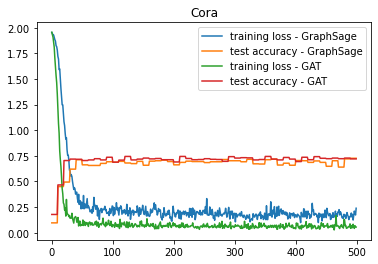

In [12]:
def main():
    for args in [
        {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
    ]:
        args = objectview(args)
        for model in ['GraphSage', 'GAT']:
            args.model_type = model

            # Match the dimension.
            if model == 'GAT':
              args.heads = 2
            else:
              args.heads = 1

            if args.dataset == 'cora':
                dataset = Planetoid(root='/tmp/cora', name='Cora')
            else:
                raise NotImplementedError("Unknown dataset") 
            test_accs, losses = train(dataset, args) 

            print("Maximum accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()

if __name__ == '__main__':
    main()

## Question 1.1: What is the maximum accuracy you could get on test set for GraphSage? (10 points)

Maximum accuracy: 0.734

## Question 1.2: What is the maximum accuracy you could get on test set for GAT? (10 points)

Maximum accuracy: 0.754

# 2 DeepSNAP Basics

In previous Colabs we used both of graph class (NetworkX) and tensor (PyG) representations of graphs separately. The graph class `nx.Graph` provides rich analysis and manipulation functionalities, such as the clustering coefficient and PageRank. To feed the graph into the model, we need to transform the graph into tensor representations including edge tensor `edge_index` and node attributes tensors `x` and `y`. But only using tensors (as the graphs formatted in PyG `datasets` and `data`) will make many graph manipulations and analysis less efficient and harder. So, in this Colab we will use DeepSNAP which combines both representations and offers a full pipeline for GNN training / validation / testing.


In general, [DeepSNAP](https://github.com/snap-stanford/deepsnap) is a Python library to assist efficient deep learning on graphs. DeepSNAP features in its support for flexible graph manipulation, standard pipeline, heterogeneous graphs and simple API.

1. DeepSNAP is easy to be used for the sophisticated graph manipulations, such as feature computation, pretraining, subgraph extraction etc. during/before the training.
2. In most frameworks, standard pipelines for node, edge, link, graph-level tasks under inductive or transductive settings are left to the user to code. In practice, there are additional design choices involved (such as how to split dataset for link prediction). DeepSNAP provides such a standard pipeline that greatly saves repetitive coding efforts, and enables fair comparision for models.
3. Many real-world graphs are heterogeneous graphs. But packages support for heterogeneous graphs, including data storage and flexible message passing, is lacking. DeepSNAP provides an efficient and flexible heterogeneous graph that supports both the node and edge heterogeneity.

[DeepSNAP](https://github.com/snap-stanford/deepsnap) is a newly released project and it is still under development. If you find any bugs or have any improvement ideas, feel free to raise issues or create pull requests on the GitHub directly :)

In this Colab, we will focus on DeepSNAP graph manipulations and splitting settings.

## Setup

In [13]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

def visualize(G, color_map=None, seed=123):
  if color_map is None:
    color_map = '#c92506'
  plt.figure(figsize=(8, 8))
  nodes = nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=seed), \
                                 label=None, node_color=color_map, node_shape='o', node_size=150)
  edges = nx.draw_networkx_edges(G, pos=nx.spring_layout(G, seed=seed), alpha=0.5)
  if color_map is not None:
    plt.scatter([],[], c='#c92506', label='Nodes with label 0', edgecolors="black", s=140)
    plt.scatter([],[], c='#fcec00', label='Nodes with label 1', edgecolors="black", s=140)
    plt.legend(prop={'size': 13}, handletextpad=0)
  nodes.set_edgecolor('black')
  plt.show()

## DeepSNAP Graph

The `deepsnap.graph.Graph` class is the core class of DeepSNAP. It not only represents a graph in tensor format but also references to a graph object from graph manipulation package.

Currently DeepSNAP supports [NetworkX](https://networkx.org/) and [Snap.py](https://snap.stanford.edu/snappy/doc/index.html) as the back end graph manipulation package.

In this Colab, we will use the NetworkX as the back end graph manipulation package.

Lets first try to convert a simple random NetworkX graph to a DeepSNAP graph.

0


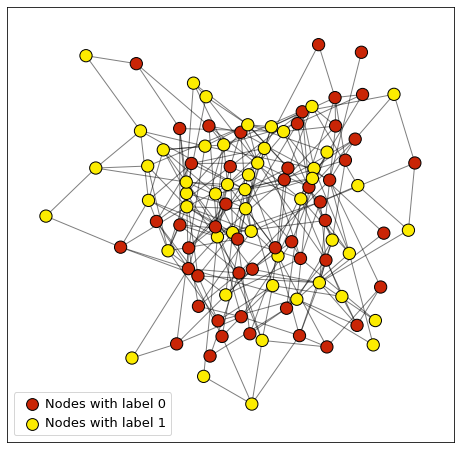

Deepsnap의 그래프는? Graph(G=[], edge_index=[2, 524], edge_label_index=[2, 524], node_feature=[100, 5], node_label=[100], node_label_index=[100])
Node feature (node_feature) has shape torch.Size([100, 5]) and type torch.float32
Node label (node_label) has shape torch.Size([100]) and type torch.int64
Edge index (edge_index) has shape torch.Size([2, 524]) and type torch.int64
The DeepSNAP graph has <class 'networkx.classes.graph.Graph'> as the internal manupulation graph


In [14]:
from deepsnap.graph import Graph               
num_nodes = 100
p = 0.05
seed = 100

# Generate a networkx random graph
G = nx.gnp_random_graph(num_nodes, p, seed=seed)

# Generate some random node features and labels
node_feature = {node : torch.rand([5, ]) for node in G.nodes()}
node_label = {node : torch.randint(0, 2, ()) for node in G.nodes()}

# Set the random features and labels to G
nx.set_node_attributes(G, node_feature, name='node_feature')
nx.set_node_attributes(G, node_label, name='node_label')

# Print one node example
for node in G.nodes(data=True):
  print(node[1]['node_label'].item())
  break

# print(G.nodes[0][])


color_map = ['#c92506' if node[1]['node_label'].item() == 0 else '#fcec00' for node in G.nodes(data=True)]
# node[1] = {'node_feature': tensor([0.1396, 0.9754, 0.3390, 0.3958, 0.2365]), 'node_label': tensor(1)}

# Visualize the graph
visualize(G, color_map=color_map)

# Transform the networkx graph into the deepsnap graph
graph = Graph(G)

# Print out the general deepsnap graph information
print('Deepsnap의 그래프는?',graph)

# DeepSNAP will convert node attributes to tensors
# Notice the type of tensors
print("Node feature (node_feature) has shape {} and type {}".format(graph.node_feature.shape, graph.node_feature.dtype))
print("Node label (node_label) has shape {} and type {}".format(graph.node_label.shape, graph.node_label.dtype))

# DeepSNAP will also generate the edge_index tensor
print("Edge index (edge_index) has shape {} and type {}".format(graph.edge_index.shape, graph.edge_index.dtype))

# Different from only storing tensors, deepsnap graph also references to the networkx graph
# We will discuss why the reference will be helpful later
print("The DeepSNAP graph has {} as the internal manupulation graph".format(type(graph.G)))

In DeepSNAP we have three levels of attributes. In this example, we have the **node level** attributes including `node_feature` and `node_label`. The other two levels of attributes are graph and edge attributes. The usage is similar to the node level one except that the feature becomes `edge_feature` or `graph_feature` and label becomes `edge_label` or `graph_label` etc.

Similar to the NetworkX graph, we can easily get some basic information of the graph through class properties directly.

In [15]:
# Number of nodes
print("The random graph has {} nodes".format(graph.num_nodes))

# Number of edges
print("The random graph has {} edges".format(graph.num_edges))

The random graph has 100 nodes
The random graph has 262 edges


DeepSNAP also provides functions that can automatically transform the PyG datasets into a list of DeepSNAP graphs.

Here we transform the CORA dataset into a list of DeepSNAP graphs.

In [16]:
root = './tmp/cora'
name = 'Cora'

# The Cora dataset
pyg_dataset= Planetoid(root, name)

# PyG dataset to a list of deepsnap graphs
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Get the first deepsnap graph (CORA only has one graph)
print(graphs)
graph = graphs[0]
print(graph)

[Graph(G=[], edge_index=[2, 10556], edge_label_index=[2, 10556], node_feature=[2708, 1433], node_label=[2708], node_label_index=[2708])]
Graph(G=[], edge_index=[2, 10556], edge_label_index=[2, 10556], node_feature=[2708, 1433], node_label=[2708], node_label_index=[2708])


Processing...
Done!


## Question 2.1: What is the number of classes and number of features in the CORA graph? (5 points)

Submit your answers on Gradescope.

In [17]:
def get_num_node_classes(graph):
  # TODO: Implement this function that takes a deepsnap graph object
  # and return the number of node classes of that graph.

  num_node_classes = 0

  ############# Your code here #############
  ## (~1 line of code)
  ## Note
  ## 1. Colab autocomplete functionality might be useful
  ## 2. DeepSNAP documentation might be useful https://snap.stanford.edu/deepsnap/modules/graph.html
  num_node_classes = graph.num_node_labels
  ##########################################

  return num_node_classes

def get_num_node_features(graph):
  # TODO: Implement this function that takes a deepsnap graph object
  # and return the number of node features of that graph.

  num_node_features = 0

  ############# Your code here #############
  ## (~1 line of code)
  ## Note
  ## 1. Colab autocomplete functionality might be useful
  ## 2. DeepSNAP documentation might be useful https://snap.stanford.edu/deepsnap/modules/graph.html
  num_node_features = graph.num_node_features
  ##########################################

  return num_node_features

num_node_classes = get_num_node_classes(graph)
num_node_features = get_num_node_features(graph)
print("{} has {} classes".format(name, num_node_classes))
print("{} has {} features".format(name, num_node_features))

Cora has 7 classes
Cora has 1433 features


## DeepSNAP Dataset

Now, lets talk about DeepSNAP dataset. A `deepsnap.dataset.GraphDataset` contains a list of `deepsnap.graph.Graph` objects. In addition to list of graphs, you can also specify what task the dataset will be used on, such as node level task (`task=node`), edge level task (`task=link_pred`) and graph level task (`task=graph`).

It also contains many other useful parameters during initialization and other functinoalities. If you are interested, you can take a look at the [documentation](https://snap.stanford.edu/deepsnap/modules/dataset.html#deepsnap-graphdataset).

Lets now use COX2 dataset which contains a list of graphs and specify the task to `graph` when we initialize the DeepSNAP dataset.

In [18]:
root = './tmp/cox2'
name = 'COX2'

# Load the dataset through PyG
pyg_dataset = TUDataset(root, name)

# Convert to a list of deepsnap graphs
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
print(len(graphs))
# Convert list of deepsnap graphs to deepsnap dataset with specified task=graph
dataset = GraphDataset(graphs, task='graph')
print(dataset)
print(type(dataset[0]))

Extracting tmp/cox2/COX2/COX2.zip
Processing...
Done!


467
GraphDataset(467)
<class 'deepsnap.graph.Graph'>


## Question 2.2: What is the label of the graph (index 100 in the COX2 dataset)? (5 points)

Submit your answers on Gradescope.

In [19]:
def get_graph_class(dataset, idx):
  # TODO: Implement this function that takes a deepsnap dataset object,
  # the index of the graph in the dataset, and returns the class/label 
  # of the graph (in integer).

  label = -1

  ############# Your code here ############
  ## (~1 line of code)
  ## Note
  ## 1. The label refers to the graph-level attribute

  label = dataset[idx].graph_label
  #########################################

  return label

graph_0 = dataset[0]
print(graph_0)
idx = 100
label = get_graph_class(dataset, idx)
print('Graph with index {} has label {}'.format(idx, label))

Graph(G=[], edge_index=[2, 82], edge_label_index=[2, 82], graph_label=[1], node_feature=[39, 35], node_label_index=[39], task=[])
Graph with index 100 has label tensor([0])


## Question 2.3: What is the number of edges for the graph (index 200 in the COX2 dataset)? (5 points)

Submit your answers on Gradescope.

In [20]:
def get_graph_num_edges(dataset, idx):
  # TODO: Implement this function that takes a deepsnap dataset object,
  # the index of the graph in dataset, and returns the number of 
  # edges in the graph (in integer).

  num_edges = 0

  ############# Your code here ############
  ## (~1 lines of code)
  ## Note
  ## 1. You can use the class property directly

  num_edges = dataset[idx].num_edges
  #########################################

  return num_edges

idx = 200
num_edges = get_graph_num_edges(dataset, idx)
print('Graph with index {} has {} edges'.format(idx, num_edges))

Graph with index 200 has 49 edges


# 3 DeepSNAP Advanced

We have learned the basic use of DeepSNAP graph and dataset :)

Lets move on to some more advanced functionalities.

In this section we will use DeepSNAP for faeture computation and transductive/inductive splittings.

## Setup

In [21]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

## Data Split in Graphs

Data splitting in graphs can be much harder than that in CV or NLP.

In general, the data splitting in graphs can be divided into two settings, **inductive** and **transductive**.

## Inductive Split

As what we have learned in the lecture, inductive setting will split multiple graphs into each training/valiation and test sets.

Here is an example of DeepSNAP inductive splitting for a list of graphs in the graph level task (graph classification etc.)

In [22]:
root = './tmp/cox2'
name = 'COX2'

pyg_dataset = TUDataset(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
print(type(graphs[0])) # <class 'deepsnap.graph.Graph'>
# Here we specify the task as graph-level task such as graph classification
task = 'graph'
dataset = GraphDataset(graphs, task=task)
print(type(dataset))   # <class 'deepsnap.dataset.GraphDataset'> 
# Specify transductive=False (inductive)
print(dataset)
dataset_train, dataset_val, dataset_test = dataset.split(transductive=False, split_ratio=[0.8, 0.1, 0.1])

print("COX2 train dataset: {}".format(dataset_train))
print("COX2 validation dataset: {}".format(dataset_val))
print("COX2 test dataset: {}".format(dataset_test))

<class 'deepsnap.graph.Graph'>
<class 'deepsnap.dataset.GraphDataset'>
GraphDataset(467)
COX2 train dataset: GraphDataset(373)
COX2 validation dataset: GraphDataset(46)
COX2 test dataset: GraphDataset(48)


## Transductive Split

In transductive setting, the training /validation / test sets are on the same graph.

Here we transductively split the CORA graph in the node level task. 

(Notice that in DeepSNAP default setting the split is random, but you can also make a fixed split by specifying `fixed_split=True` when loading the dataset from PyG or changing the `node_label_index` directly).

In [23]:
root = './tmp/cora'
name = 'Cora'

pyg_dataset = Planetoid(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Here we specify the task as node-level task such as node classification
task = 'node'

dataset = GraphDataset(graphs, task=task)
print(dataset.num_nodes[0])
# Specify we want the transductive splitting
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

print("Cora train dataset: {}".format(dataset_train))
print("Cora validation dataset: {}".format(dataset_val))
print("Cora test dataset: {}".format(dataset_test))

print("Original Cora has {} nodes".format(dataset.num_nodes[0]))

# The nodes in each set can be find in node_label_index
print("After the split, Cora has {} training nodes".format(dataset_train[0].node_label_index.shape[0]))
print("After the split, Cora has {} validation nodes".format(dataset_val[0].node_label_index.shape[0]))
print("After the split, Cora has {} test nodes".format(dataset_test[0].node_label_index.shape[0]))

2708
Cora train dataset: GraphDataset(1)
Cora validation dataset: GraphDataset(1)
Cora test dataset: GraphDataset(1)
Original Cora has 2708 nodes
After the split, Cora has 2166 training nodes
After the split, Cora has 270 validation nodes
After the split, Cora has 272 test nodes


## Edge Level Split

Compared to the node and graph level splitting, edge level splitting is a little bit tricky ;)

Usually in edge level splitting, we need to sample negative edges, split positive edges into different datasets, split training edges into message passing edges and supervision edges, and resample the negative edges during the training etc.

### All Mode

Now lets start with a simpler edge level splitting mode, the `edge_train_mode="all"` mode in DeepSNAP.

In [24]:
root = './tmp/cora'
name = 'Cora'

pyg_dataset = Planetoid(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Specify task as link_pred for edge-level task
task = 'link_pred'

# Specify the train mode, "all" mode is default for deepsnap dataset
edge_train_mode = "all"

dataset = GraphDataset(graphs, task=task, edge_train_mode=edge_train_mode)

# Transductive link prediction split
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

print("Cora train dataset: {}".format(dataset_train))
print("Cora validation dataset: {}".format(dataset_val))
print("Cora test dataset: {}".format(dataset_test))

Cora train dataset: GraphDataset(1)
Cora validation dataset: GraphDataset(1)
Cora test dataset: GraphDataset(1)


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


In DeepSNAP, the indices of supervision edges are stored in `edge_label_index` tensor and the corresponding edge labels are stored in `edge_label` tensor.

In [25]:
print("Original Cora graph has {} edges".format(dataset[0].num_edges))
print("Because Cora graph is undirected, the original edge_index has shape {}".format(dataset[0].edge_index.shape))

print("The training set has message passing edge index shape {}".format(dataset_train[0].edge_index.shape))
print("The training set has supervision edge index shape {}".format(dataset_train[0].edge_label_index.shape))

print("The validation set has message passing edge index shape {}".format(dataset_val[0].edge_index.shape))
print("The validation set has supervision edge index shape {}".format(dataset_val[0].edge_label_index.shape))

print("The test set has message passing edge index shape {}".format(dataset_test[0].edge_index.shape))
print("The test set has supervision edge index shape {}".format(dataset_test[0].edge_label_index.shape))

Original Cora graph has 5278 edges
Because Cora graph is undirected, the original edge_index has shape torch.Size([2, 10556])
The training set has message passing edge index shape torch.Size([2, 8444])
The training set has supervision edge index shape torch.Size([2, 16888])
The validation set has message passing edge index shape torch.Size([2, 8444])
The validation set has supervision edge index shape torch.Size([2, 2108])
The test set has message passing edge index shape torch.Size([2, 9498])
The test set has supervision edge index shape torch.Size([2, 2116])


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


We can see that both training and validation sets have the same message passing edges (`edge_index`) in the `all` mode. Also, in training set, the postive supervision edges (`edge_label_index`) are same with the message passing edges. However, in the test set the message passing edges are the combination of message passing edges from training and validation sets.

Notice that the `edge_label` and `edge_label_index` have included the negative edges (default number of negative edges is same with the number of positive edges).

Now, lets implement a function that checks whether two edge index tensors are disjoint and explore more edge splitting properties by using that function.

## Question 3.1 - 3.5: Implement the function that checks whether two edge_index tensors are disjoint. Then answer the True/False questions below. (5 points)

Submit your answers on Gradescope.

In [35]:
def edge_indices_disjoint(edge_index_1, edge_index_2):
  # TODO: Implement this function that takes two edge index tensors,
  # and returns whether these two edge index tensors are disjoint.
  disjoint = None

  ############# Your code here ############
  ## (~5 lines of code)
  ## Note
  ## 1. Here disjoint means that there is no single edge belongs to either edge index tensors
  ## 2. You do not need to consider the undirected case. For example, if edge_index_1 contains
  ## edge (a, b) and edge_index_2 contains edge (b, a). We will treat them as disjoint in this
  ## function.
#   print('edge_index_1',edge_index_1.shape)
#   print('edge_index_2',edge_index_2.shape)
  disjoint = True
  edge_set_1 = set([i for i in edge_index_1.reshape(-1,2)])
  for t in edge_index_2.reshape(-1,2):
      if t in edge_set_1:
          disjoint=False
          break

  #########################################

  return disjoint

In [36]:
print(dataset_train[0])
num_train_edges = dataset_train[0].edge_label_index.shape[1] // 2
train_pos_edge_index = dataset_train[0].edge_label_index[:, :num_train_edges]
train_neg_edge_index = dataset_train[0].edge_label_index[:, num_train_edges:]
print("3.1 Training (supervision) positve and negative edges are disjoint = {}"\
        .format(edge_indices_disjoint(train_pos_edge_index, train_neg_edge_index)))

num_val_edges = dataset_val[0].edge_label_index.shape[1] // 2
val_pos_edge_index = dataset_val[0].edge_label_index[:, :num_val_edges]
val_neg_edge_index = dataset_val[0].edge_label_index[:, num_val_edges:]
print("3.2 Validation (supervision) positve and negative edges are disjoint = {}"\
        .format(edge_indices_disjoint(val_pos_edge_index, val_neg_edge_index)))

num_test_edges = dataset_test[0].edge_label_index.shape[1] // 2
test_pos_edge_index = dataset_test[0].edge_label_index[:, :num_test_edges]
test_neg_edge_index = dataset_test[0].edge_label_index[:, num_test_edges:]
print("3.3 Test (supervision) positve and negative edges are disjoint = {}"\
        .format(edge_indices_disjoint(test_pos_edge_index, test_neg_edge_index)))

print("3.4 Test (supervision) positve and validation (supervision) positve edges are disjoint = {}"\
        .format(edge_indices_disjoint(test_pos_edge_index, val_pos_edge_index)))
print("3.5 Validation (supervision) positve and training (supervision) positve edges are disjoint = {}"\
        .format(edge_indices_disjoint(val_pos_edge_index, train_pos_edge_index)))

Graph(G=[], edge_index=[2, 8444], edge_label=[16888], edge_label_index=[2, 16888], negative_label_val=[1], node_feature=[2708, 1433], node_label=[2708], node_label_index=[2708])
3.1 Training (supervision) positve and negative edges are disjoint = True
3.2 Validation (supervision) positve and negative edges are disjoint = True
3.3 Test (supervision) positve and negative edges are disjoint = True
3.4 Test (supervision) positve and validation (supervision) positve edges are disjoint = True
3.5 Validation (supervision) positve and training (supervision) positve edges are disjoint = True


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


### Disjoint Mode

Now lets look at a relatively more complex transductive edge split setting, which is the `edge_train_mode="disjoint"` mode in DeepSNAP (also the transductive link prediction splitting talked in the lecture)

In [ ]:
edge_train_mode = "disjoint"

dataset = GraphDataset(graphs, task='link_pred', edge_train_mode=edge_train_mode)
orig_edge_index = dataset[0].edge_index
dataset_train, dataset_val, dataset_test = dataset.split(
    transductive=True, split_ratio=[0.8, 0.1, 0.1])

train_message_edge_index = dataset_train[0].edge_index
train_sup_edge_index = dataset_train[0].edge_label_index
val_sup_edge_index = dataset_val[0].edge_label_index
test_sup_edge_index = dataset_test[0].edge_label_index

print("The edge index of original graph has shape: {}".format(orig_edge_index.shape))
print("The edge index of training message edges has shape: {}".format(train_message_edge_index.shape))
print("The edge index of training supervision edges has shape: {}".format(train_sup_edge_index.shape))
print("The edge index of validation message edges has shape: {}".format(dataset_val[0].edge_index.shape))
print("The edge index of validation supervision edges has shape: {}".format(val_sup_edge_index.shape))
print("The edge index of test message edges has shape: {}".format(dataset_test[0].edge_index.shape))
print("The edge index of test supervision edges has shape: {}".format(test_sup_edge_index.shape))

You can see that the training / validation message passing edges and training supervision edges are splitted differently in those two modes!

### Resample Negative Edges

During each training iteration, we usually need to resample the negative edges.

Below we print the training and validation sets negative edges in two training iterations.

You should find that the negative edges in training set will be resampled.

In [72]:
dataset = GraphDataset(graphs, task='link_pred', edge_train_mode="disjoint")
datasets = {}
follow_batch = []
datasets['train'], datasets['val'], datasets['test'] = dataset.split(
    transductive=True, split_ratio=[0.8, 0.1, 0.1])
print(datasets.items()) # dict_items([('train', GraphDataset(1)), ('val', GraphDataset(1)), ('test', GraphDataset(1))])
dataloaders = {
  split: DataLoader(
    ds, collate_fn=Batch.collate(follow_batch),
    batch_size=1, shuffle=(split=='train')
  )
  for split, ds in datasets.items()
}
neg_edges_1 = None
for batch in dataloaders['train']:
  print(batch)
  num_edges = batch.edge_label_index.shape[1] // 2
  print('num_edges in train1',num_edges)
  neg_edges_1 = batch.edge_label_index[:, num_edges:]
  print("First iteration training negative edges:")
  print(neg_edges_1)
  break
neg_edges_2 = None
for batch in dataloaders['train']:
  num_edges = batch.edge_label_index.shape[1] // 2
  print('num_edges in train2',num_edges)
  neg_edges_2 = batch.edge_label_index[:, num_edges:]
  print("Second iteration training negative edges:")
  print(neg_edges_2)
  break

neg_edges_1 = None
for batch in dataloaders['val']:
  num_edges = batch.edge_label_index.shape[1] // 2
  print('num_edges in val',num_edges)
  neg_edges_1 = batch.edge_label_index[:, num_edges:]
  print("First iteration validation negative edges:")
  print(neg_edges_1)
  break
neg_edges_2 = None
for batch in dataloaders['val']:
  num_edges = batch.edge_label_index.shape[1] // 2
  print('num_edges in val',num_edges)
  neg_edges_2 = batch.edge_label_index[:, num_edges:]
  print("Second iteration validation negative edges:")
  print(neg_edges_2)
  break

dict_items([('train', GraphDataset(1)), ('val', GraphDataset(1)), ('test', GraphDataset(1))])
Batch(G=[1], batch=[2708], edge_index=[2, 6754], edge_label=[3380], edge_label_index=[2, 3380], negative_label_val=[1], node_feature=[2708, 1433], node_label=[2708], node_label_index=[2708])
num_edges in train1 1690
First iteration training negative edges:
tensor([[1011,  366, 1119,  ..., 1088, 2688,  983],
        [ 441, 1743, 2037,  ...,  262, 1094, 1089]])
num_edges in train2 1690
Second iteration training negative edges:
tensor([[1353, 2539, 1833,  ..., 2358, 1092,  360],
        [1874, 1180, 2227,  ..., 1532,  337,  423]])
num_edges in val 1054
First iteration validation negative edges:
tensor([[  12, 1126, 2552,  ...,   76, 1377, 1604],
        [1818, 2154,  474,  ...,  862, 2677, 2089]])
num_edges in val 1054
Second iteration validation negative edges:
tensor([[  12, 1126, 2552,  ...,   76, 1377, 1604],
        [1818, 2154,  474,  ...,  862, 2677, 2089]])


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


If you are interested in more graph splitting settings, please refer to the DeepSNAP dataset [documentation](https://snap.stanford.edu/deepsnap/modules/dataset.html).

## Graph Transformation and Feature Computation

The other DeepSNAP core functionality is graph transformation / feature computation.

In DeepSNAP, we divide graph transformation / feature computation into two different types. One is the transformation before training (transform the whole dataset before training directly) and another one is the transformation during training (transform batches of graphs).

Here is an example that uses NetworkX back end to calculate the PageRank value and update the value to tensors before the training (transform the dataset).

In [53]:
def pagerank_transform_fn(graph):

  # Get the referenced networkx graph
  G = graph.G

  # Calculate the pagerank by using networkx
  pr = nx.pagerank(G)

  # Transform the pagerank values to tensor
  pr_feature = torch.tensor([pr[node] for node in range(graph.num_nodes)], dtype=torch.float32)
  pr_feature = pr_feature.view(graph.num_nodes, 1)

  # Concat the pagerank values to the node feature
  graph.node_feature = torch.cat([graph.node_feature, pr_feature], dim=-1)

root = './tmp/cox2'
name = 'COX2'
pyg_dataset = TUDataset(root, name)
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task='graph')
print("Number of features before transformation: {}".format(dataset.num_node_features))
dataset.apply_transform(pagerank_transform_fn, update_tensor=False)
print("Number of features after transformation: {}".format(dataset.num_node_features))

Number of features before transformation: 35
Number of features after transformation: 36


## Question 3.6: Implement the transformation below and report the clustering coefficient of the node (index 3) of the graph (index 406) in the COX2 dataset. Rounded the answer to two decimal places. (5 points)

In [54]:
def cluster_transform_fn(graph):
  # TODO: Implement this function that takes an deepsnap graph object,
  # transform the graph by adding nodes clustering coefficient into the 
  # graph.node_feature

  ############# Your code here ############
  ## (~5 lines of code)
  ## Note
  ## 1. Compute the clustering coefficient value for each node and
  ## concat them to the last dimension of graph.node_feature
  G = graph.G
  cc = nx.clustering(G)

  cc_feature = torch.tensor([cc[node] for node in range(graph.num_nodes)],dtype=torch.float32)
  cc_feature = cc_feature.view(graph.num_nodes, 1)

  graph.node_feature = torch.cat([graph.node_feature,cc_feature],dim=-1)


  #########################################

root = './cox2'
name = 'COX2'
pyg_dataset = TUDataset(root, name)
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task='graph')

# Transform the dataset
dataset.apply_transform(cluster_transform_fn, update_tensor=False)

node_idx = 3
graph_idx = 406
node_feature = dataset[graph_idx].node_feature
print(node_feature[3])
print("The node has clustering coefficient: {}".format(round(node_feature[node_idx][-1].item(), 2)))

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667])
The node has clustering coefficient: 0.17


Apart from transforming the dataset, DeepSNAP can also transform the graph (usually the `deepsnap.batch.Batch`) during each training iteration.

Also, DeepSNAP supports the synchronization of the transformation between the referenced graph objects and tensor representations. For example, you can just update the NetworkX graph object in the transform function, and by specifying `update_tensor=True` the internal tensor representations will be automatically updated.

For more information, please refer to the DeepSNAP [documentation](https://snap.stanford.edu/deepsnap/).

# 4 Edge Level Prediction

From last section, we know how DeepSNAP transductive split the edges in the link prediction task.

Now lets use DeepSNAP and PyG together to implement a edge level prediction (link prediction) model!

In [55]:
import copy
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class LinkPredModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.2):
        super(LinkPredModel, self).__init__()

        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, num_classes)

        self.loss_fn = None

        ############# Your code here #############
        ## (~1 line of code)
        ## Note
        ## 1. Initialize the loss function to BCEWithLogitsLoss
        self.loss_fn = nn.BCEWithLogitsLoss()
        ##########################################

        self.dropout = dropout

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, batch):
        node_feature, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        
        ############# Your code here #############
        ## (~6 line of code)
        ## Note
        ## 1. Feed the node feature into the first conv layer
        ## 2. Add a ReLU after the first conv layer
        ## 3. Add dropout after the ReLU (with probability self.dropout)
        ## 4. Feed the output to the second conv layer
        ## 5. Select the embeddings of the source nodes and destination nodes
        ## by using the edge_label_index and compute the similarity of each pair
        ## by dot product
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.SAGEConv
        out = self.conv1(node_feature,edge_index)
        out = F.relu(out)
        out = F.dropout(out,p=self.dropout)
        out = self.conv2(out,edge_index)
        out = out[edge_label_index[0]] * out[edge_label_index[1]]
        pred = torch.sum(out,-1)

        
        ##########################################

        return pred
    
    def loss(self, pred, link_label):
        return self.loss_fn(pred, link_label)

In [69]:
from sklearn.metrics import *

def train(model, dataloaders, optimizer, args):
    val_max = 0
    best_model = model

    for epoch in range(1, args["epochs"]):
        for i, batch in enumerate(dataloaders['train']):
            
            batch.to(args["device"])

            ############# Your code here #############
            ## (~6 lines of code)
            ## Note
            ## 1. Zero grad the optimizer
            ## 2. Compute loss and backpropagate
            ## 3. Update the model parameters
            optimizer.zero_grad()
            pred = model(batch)
            loss = model.loss(pred,batch.edge_label.float())
            loss.backward()
            optimizer.step()
            ##########################################

            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}, Loss: {}'
            score_train = test(model, dataloaders['train'], args)
            score_val = test(model, dataloaders['val'], args)
            score_test = test(model, dataloaders['test'], args)

            print(log.format(epoch, score_train, score_val, score_test, loss.item()))
            if val_max < score_val:
                val_max = score_val
                best_model = copy.deepcopy(model)
    return best_model

def test(model, dataloader, args):
    model.eval()

    score = 0

    ############# Your code here #############
    ## (~5 lines of code)
    ## Note
    ## 1. Loop through batches in the dataloader
    ## 2. Feed the batch to the model
    ## 3. Feed the model output to sigmoid
    ## 4. Compute the ROC-AUC score by using sklearn roc_auc_score function
    ## 5. Edge labels are stored in batch.edge_label
    for i, batch in enumerate(dataloaders['test']):
        batch.to(args['device'])
        pred = model(batch)
        pred = torch.sigmoid(pred)
        score += roc_auc_score(batch.edge_label.cpu().detach().numpy(),pred.cpu().detach().numpy())
    score /= len(dataloaders['test'])

    
    ##########################################
 
    return score

In [70]:
# Please don't change any parameters
args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_dim" : 128,
    "epochs" : 200,
}

In [71]:
pyg_dataset = Planetoid('./tmp/cora', 'Cora')
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

dataset = GraphDataset(
        graphs,
        task='link_pred',
        edge_train_mode="disjoint"
    )
datasets = {}
datasets['train'], datasets['val'], datasets['test']= dataset.split(
            transductive=True, split_ratio=[0.85, 0.05, 0.1])
input_dim = datasets['train'].num_node_features
num_classes = datasets['train'].num_edge_labels

model = LinkPredModel(input_dim, args["hidden_dim"], num_classes).to(args["device"])
model.reset_parameters()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

dataloaders = {split: DataLoader(
            ds, collate_fn=Batch.collate([]),
            batch_size=1, shuffle=(split=='train'))
            for split, ds in datasets.items()}
best_model = train(model, dataloaders, optimizer, args)
log = "Train: {:.4f}, Val: {:.4f}, Test: {:.4f}"
best_train_roc = test(best_model, dataloaders['train'], args)
best_val_roc = test(best_model, dataloaders['val'], args)
best_test_roc = test(best_model, dataloaders['test'], args)
print(log.format(best_train_roc, best_val_roc, best_test_roc))

/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 001, Train: 0.5320, Val: 0.5258, Test: 0.5341, Loss: 0.6930607557296753
Epoch: 002, Train: 0.5314, Val: 0.5220, Test: 0.5265, Loss: 0.6930938959121704
Epoch: 003, Train: 0.5378, Val: 0.5282, Test: 0.5236, Loss: 0.6930387020111084


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 004, Train: 0.5346, Val: 0.5324, Test: 0.5551, Loss: 0.6930232048034668
Epoch: 005, Train: 0.5136, Val: 0.5507, Test: 0.5436, Loss: 0.6930382251739502
Epoch: 006, Train: 0.5273, Val: 0.5246, Test: 0.5485, Loss: 0.6930367350578308


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 007, Train: 0.5481, Val: 0.5226, Test: 0.5489, Loss: 0.6931142807006836
Epoch: 008, Train: 0.5375, Val: 0.5350, Test: 0.5391, Loss: 0.6929848790168762
Epoch: 009, Train: 0.5434, Val: 0.5479, Test: 0.5200, Loss: 0.6930414438247681


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 010, Train: 0.5383, Val: 0.5359, Test: 0.5506, Loss: 0.6929596066474915
Epoch: 011, Train: 0.5449, Val: 0.5334, Test: 0.5527, Loss: 0.6929147243499756
Epoch: 012, Train: 0.5388, Val: 0.5547, Test: 0.5610, Loss: 0.6929062008857727


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 013, Train: 0.5407, Val: 0.5361, Test: 0.5491, Loss: 0.6929284930229187
Epoch: 014, Train: 0.5558, Val: 0.5418, Test: 0.5568, Loss: 0.6928855180740356
Epoch: 015, Train: 0.5402, Val: 0.5388, Test: 0.5542, Loss: 0.6928991675376892


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 016, Train: 0.5491, Val: 0.5488, Test: 0.5710, Loss: 0.6928641200065613
Epoch: 017, Train: 0.5599, Val: 0.5616, Test: 0.5592, Loss: 0.6928700804710388
Epoch: 018, Train: 0.5652, Val: 0.5437, Test: 0.5601, Loss: 0.6927834749221802


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 019, Train: 0.5499, Val: 0.5527, Test: 0.5631, Loss: 0.6927642822265625
Epoch: 020, Train: 0.5631, Val: 0.5544, Test: 0.5528, Loss: 0.6927932500839233
Epoch: 021, Train: 0.5658, Val: 0.5544, Test: 0.5648, Loss: 0.6926974058151245


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 022, Train: 0.5626, Val: 0.5569, Test: 0.5739, Loss: 0.6926931738853455
Epoch: 023, Train: 0.5605, Val: 0.5616, Test: 0.5720, Loss: 0.6926863789558411
Epoch: 024, Train: 0.5756, Val: 0.5784, Test: 0.5654, Loss: 0.6925643086433411


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 025, Train: 0.5660, Val: 0.5681, Test: 0.5697, Loss: 0.692516028881073
Epoch: 026, Train: 0.5633, Val: 0.5789, Test: 0.5700, Loss: 0.6924731731414795
Epoch: 027, Train: 0.5778, Val: 0.5589, Test: 0.5747, Loss: 0.6923608183860779


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 028, Train: 0.5738, Val: 0.5705, Test: 0.5718, Loss: 0.6923116445541382
Epoch: 029, Train: 0.5739, Val: 0.5754, Test: 0.5625, Loss: 0.6923789978027344
Epoch: 030, Train: 0.5664, Val: 0.5896, Test: 0.5881, Loss: 0.6923615336418152


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 031, Train: 0.5727, Val: 0.5767, Test: 0.5694, Loss: 0.6923187971115112


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 032, Train: 0.5886, Val: 0.5797, Test: 0.5806, Loss: 0.6920838952064514
Epoch: 033, Train: 0.5803, Val: 0.5815, Test: 0.5850, Loss: 0.6920974254608154

/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes



Epoch: 034, Train: 0.5941, Val: 0.5666, Test: 0.5791, Loss: 0.6920408010482788


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 035, Train: 0.5786, Val: 0.5790, Test: 0.5808, Loss: 0.6915577054023743
Epoch: 036, Train: 0.5870, Val: 0.5771, Test: 0.5773, Loss: 0.6916245818138123
Epoch: 037, Train: 0.5805, Val: 0.5724, Test: 0.5778, Loss: 0.6917375922203064


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 038, Train: 0.5858, Val: 0.5731, Test: 0.5814, Loss: 0.6914626955986023
Epoch: 039, Train: 0.5832, Val: 0.5804, Test: 0.5899, Loss: 0.6913253664970398
Epoch: 040, Train: 0.5892, Val: 0.5796, Test: 0.5858, Loss: 0.6914588212966919


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 041, Train: 0.5951, Val: 0.5816, Test: 0.5858, Loss: 0.691066563129425
Epoch: 042, Train: 0.5877, Val: 0.5856, Test: 0.5785, Loss: 0.6907187104225159
Epoch: 043, Train: 0.5921, Val: 0.5980, Test: 0.5904, Loss: 0.6909231543540955


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 044, Train: 0.5848, Val: 0.5885, Test: 0.5835, Loss: 0.6907859444618225
Epoch: 045, Train: 0.5895, Val: 0.5805, Test: 0.5863, Loss: 0.6904011368751526
Epoch: 046, Train: 0.5853, Val: 0.5892, Test: 0.5928, Loss: 0.6901004314422607


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 047, Train: 0.5938, Val: 0.5882, Test: 0.5759, Loss: 0.6896904706954956
Epoch: 048, Train: 0.5860, Val: 0.5941, Test: 0.5876, Loss: 0.6892962455749512
Epoch: 049, Train: 0.5925, Val: 0.5990, Test: 0.5933, Loss: 0.6893022656440735


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 050, Train: 0.5913, Val: 0.5957, Test: 0.5947, Loss: 0.6888861656188965
Epoch: 051, Train: 0.5898, Val: 0.5911, Test: 0.5871, Loss: 0.6889036297798157
Epoch: 052, Train: 0.5954, Val: 0.5947, Test: 0.5928, Loss: 0.6886391639709473


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 053, Train: 0.5883, Val: 0.5958, Test: 0.5914, Loss: 0.6880810260772705
Epoch: 054, Train: 0.5966, Val: 0.5918, Test: 0.5864, Loss: 0.687548816204071
Epoch: 055, Train: 0.5972, Val: 0.5929, Test: 0.5990, Loss: 0.6870924830436707


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 056, Train: 0.5960, Val: 0.6035, Test: 0.5973, Loss: 0.6866633296012878
Epoch: 057, Train: 0.5987, Val: 0.5958, Test: 0.6088, Loss: 0.6863455176353455
Epoch: 058, Train: 0.6044, Val: 0.6038, Test: 0.6036, Loss: 0.6852559447288513


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 059, Train: 0.6010, Val: 0.6004, Test: 0.5984, Loss: 0.6855269074440002
Epoch: 060, Train: 0.6071, Val: 0.6019, Test: 0.6014, Loss: 0.6837109327316284
Epoch: 061, Train: 0.6039, Val: 0.6116, Test: 0.6003, Loss: 0.682927131652832


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 062, Train: 0.6105, Val: 0.6062, Test: 0.6069, Loss: 0.6830055713653564
Epoch: 063, Train: 0.6137, Val: 0.6100, Test: 0.6111, Loss: 0.6815592050552368
Epoch: 064, Train: 0.6160, Val: 0.6142, Test: 0.6152, Loss: 0.6800119280815125


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 065, Train: 0.6145, Val: 0.6160, Test: 0.6222, Loss: 0.6796171069145203
Epoch: 066, Train: 0.6203, Val: 0.6202, Test: 0.6256, Loss: 0.6779471635818481
Epoch: 067, Train: 0.6320, Val: 0.6311, Test: 0.6274, Loss: 0.6771420836448669


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 068, Train: 0.6315, Val: 0.6346, Test: 0.6411, Loss: 0.6745747327804565
Epoch: 069, Train: 0.6448, Val: 0.6446, Test: 0.6430, Loss: 0.673646867275238
Epoch: 070, Train: 0.6566, Val: 0.6542, Test: 0.6565, Loss: 0.6716268658638


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 071, Train: 0.6695, Val: 0.6692, Test: 0.6639, Loss: 0.6680955290794373
Epoch: 072, Train: 0.6795, Val: 0.6833, Test: 0.6791, Loss: 0.6655910611152649
Epoch: 073, Train: 0.6898, Val: 0.6866, Test: 0.6896, Loss: 0.6662113666534424


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 074, Train: 0.6930, Val: 0.7017, Test: 0.7018, Loss: 0.6613984704017639
Epoch: 075, Train: 0.7117, Val: 0.7062, Test: 0.7127, Loss: 0.6606876254081726
Epoch: 076, Train: 0.7122, Val: 0.7121, Test: 0.7192, Loss: 0.6529826521873474


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 077, Train: 0.7186, Val: 0.7169, Test: 0.7159, Loss: 0.6518374085426331
Epoch: 078, Train: 0.7215, Val: 0.7210, Test: 0.7230, Loss: 0.6486620903015137
Epoch: 079, Train: 0.7166, Val: 0.7201, Test: 0.7236, Loss: 0.6391701102256775


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 080, Train: 0.7153, Val: 0.7177, Test: 0.7205, Loss: 0.6353456377983093
Epoch: 081, Train: 0.7206, Val: 0.7226, Test: 0.7171, Loss: 0.638360857963562
Epoch: 082, Train: 0.7175, Val: 0.7181, Test: 0.7129, Loss: 0.6185500621795654


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 083, Train: 0.7167, Val: 0.7162, Test: 0.7213, Loss: 0.6199607849121094
Epoch: 084, Train: 0.7178, Val: 0.7156, Test: 0.7156, Loss: 0.6124652624130249
Epoch: 085, Train: 0.7170, Val: 0.7184, Test: 0.7208, Loss: 0.6106733679771423


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 086, Train: 0.7236, Val: 0.7173, Test: 0.7190, Loss: 0.6153252124786377
Epoch: 087, Train: 0.7155, Val: 0.7155, Test: 0.7190, Loss: 0.6148192286491394
Epoch: 088, Train: 0.7200, Val: 0.7165, Test: 0.7199, Loss: 0.6099410057067871


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 089, Train: 0.7183, Val: 0.7156, Test: 0.7161, Loss: 0.6127996444702148
Epoch: 090, Train: 0.7152, Val: 0.7167, Test: 0.7149, Loss: 0.6065082550048828
Epoch: 091, Train: 0.7203, Val: 0.7177, Test: 0.7183, Loss: 0.6209105253219604


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 092, Train: 0.7228, Val: 0.7234, Test: 0.7201, Loss: 0.6095696091651917
Epoch: 093, Train: 0.7281, Val: 0.7241, Test: 0.7248, Loss: 0.6051979660987854
Epoch: 094, Train: 0.7268, Val: 0.7287, Test: 0.7271, Loss: 0.5978109240531921


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 095, Train: 0.7266, Val: 0.7286, Test: 0.7262, Loss: 0.5951167345046997
Epoch: 096, Train: 0.7287, Val: 0.7305, Test: 0.7310, Loss: 0.606681764125824
Epoch: 097, Train: 0.7315, Val: 0.7350, Test: 0.7361, Loss: 0.5958273410797119


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 098, Train: 0.7374, Val: 0.7356, Test: 0.7336, Loss: 0.5926627516746521
Epoch: 099, Train: 0.7397, Val: 0.7402, Test: 0.7368, Loss: 0.5879232883453369
Epoch: 100, Train: 0.7361, Val: 0.7381, Test: 0.7377, Loss: 0.5972734689712524


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 101, Train: 0.7364, Val: 0.7426, Test: 0.7380, Loss: 0.5922487378120422
Epoch: 102, Train: 0.7394, Val: 0.7351, Test: 0.7366, Loss: 0.5850171446800232
Epoch: 103, Train: 0.7390, Val: 0.7415, Test: 0.7372, Loss: 0.5867266654968262


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 104, Train: 0.7395, Val: 0.7423, Test: 0.7405, Loss: 0.5912579894065857
Epoch: 105, Train: 0.7403, Val: 0.7426, Test: 0.7422, Loss: 0.5800560712814331
Epoch: 106, Train: 0.7418, Val: 0.7411, Test: 0.7413, Loss: 0.5801644325256348


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 107, Train: 0.7388, Val: 0.7420, Test: 0.7412, Loss: 0.5802122950553894
Epoch: 108, Train: 0.7361, Val: 0.7427, Test: 0.7395, Loss: 0.5805799961090088
Epoch: 109, Train: 0.7420, Val: 0.7458, Test: 0.7429, Loss: 0.5791095495223999


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 110, Train: 0.7449, Val: 0.7446, Test: 0.7442, Loss: 0.571224570274353
Epoch: 111, Train: 0.7460, Val: 0.7499, Test: 0.7472, Loss: 0.5800989270210266
Epoch: 112, Train: 0.7419, Val: 0.7423, Test: 0.7407, Loss: 0.5901822447776794


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 113, Train: 0.7414, Val: 0.7385, Test: 0.7402, Loss: 0.5696813464164734
Epoch: 114, Train: 0.7383, Val: 0.7416, Test: 0.7401, Loss: 0.589196503162384
Epoch: 115, Train: 0.7387, Val: 0.7402, Test: 0.7425, Loss: 0.5803372859954834


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 116, Train: 0.7470, Val: 0.7458, Test: 0.7451, Loss: 0.5720590353012085
Epoch: 117, Train: 0.7453, Val: 0.7488, Test: 0.7472, Loss: 0.5578778982162476
Epoch: 118, Train: 0.7444, Val: 0.7443, Test: 0.7499, Loss: 0.558623194694519


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 119, Train: 0.7472, Val: 0.7494, Test: 0.7477, Loss: 0.5670022368431091
Epoch: 120, Train: 0.7443, Val: 0.7458, Test: 0.7453, Loss: 0.5608806014060974
Epoch: 121, Train: 0.7383, Val: 0.7411, Test: 0.7397, Loss: 0.5595991611480713


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 122, Train: 0.7379, Val: 0.7394, Test: 0.7393, Loss: 0.5495682954788208
Epoch: 123, Train: 0.7408, Val: 0.7406, Test: 0.7383, Loss: 0.5646401643753052
Epoch: 124, Train: 0.7469, Val: 0.7476, Test: 0.7493, Loss: 0.5595218539237976


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 125, Train: 0.7483, Val: 0.7499, Test: 0.7498, Loss: 0.5539752244949341
Epoch: 126, Train: 0.7460, Val: 0.7445, Test: 0.7489, Loss: 0.5539514422416687
Epoch: 127, Train: 0.7470, Val: 0.7424, Test: 0.7422, Loss: 0.5609675645828247


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 128, Train: 0.7404, Val: 0.7429, Test: 0.7420, Loss: 0.5567355155944824
Epoch: 129, Train: 0.7430, Val: 0.7451, Test: 0.7483, Loss: 0.5456612706184387
Epoch: 130, Train: 0.7512, Val: 0.7395, Test: 0.7423, Loss: 0.5539717078208923


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 131, Train: 0.7502, Val: 0.7472, Test: 0.7470, Loss: 0.5500974655151367
Epoch: 132, Train: 0.7464, Val: 0.7489, Test: 0.7487, Loss: 0.5431360006332397
Epoch: 133, Train: 0.7460, Val: 0.7536, Test: 0.7488, Loss: 0.5482958555221558


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 134, Train: 0.7508, Val: 0.7462, Test: 0.7489, Loss: 0.5495143532752991
Epoch: 135, Train: 0.7504, Val: 0.7498, Test: 0.7495, Loss: 0.5384394526481628
Epoch: 136, Train: 0.7513, Val: 0.7519, Test: 0.7490, Loss: 0.5525030493736267


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 137, Train: 0.7544, Val: 0.7567, Test: 0.7581, Loss: 0.5520461201667786
Epoch: 138, Train: 0.7563, Val: 0.7560, Test: 0.7555, Loss: 0.5439879298210144
Epoch: 139, Train: 0.7556, Val: 0.7550, Test: 0.7559, Loss: 0.5387905836105347


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 140, Train: 0.7559, Val: 0.7582, Test: 0.7574, Loss: 0.5367242693901062
Epoch: 141, Train: 0.7564, Val: 0.7567, Test: 0.7562, Loss: 0.5501514673233032
Epoch: 142, Train: 0.7559, Val: 0.7582, Test: 0.7546, Loss: 0.5428993105888367


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 143, Train: 0.7636, Val: 0.7666, Test: 0.7650, Loss: 0.5290483236312866
Epoch: 144, Train: 0.7661, Val: 0.7666, Test: 0.7659, Loss: 0.5418733358383179


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 145, Train: 0.7647, Val: 0.7686, Test: 0.7667, Loss: 0.5300191640853882
Epoch: 146, Train: 0.7673, Val: 0.7658, Test: 0.7668, Loss: 0.541374683380127
Epoch: 147, Train: 0.7619, Val: 0.7660, Test: 0.7668, Loss: 0.5433533191680908


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 148, Train: 0.7706, Val: 0.7677, Test: 0.7701, Loss: 0.5366334915161133
Epoch: 149, Train: 0.7704, Val: 0.7712, Test: 0.7674, Loss: 0.5327526330947876
Epoch: 150, Train: 0.7707, Val: 0.7774, Test: 0.7683, Loss: 0.5276646018028259


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 151, Train: 0.7730, Val: 0.7750, Test: 0.7754, Loss: 0.5252190232276917
Epoch: 152, Train: 0.7754, Val: 0.7765, Test: 0.7796, Loss: 0.5189176201820374
Epoch: 153, Train: 0.7768, Val: 0.7797, Test: 0.7724, Loss: 0.5240171551704407


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 154, Train: 0.7734, Val: 0.7737, Test: 0.7780, Loss: 0.5264744758605957
Epoch: 155, Train: 0.7770, Val: 0.7771, Test: 0.7733, Loss: 0.5247796177864075
Epoch: 156, Train: 0.7824, Val: 0.7783, Test: 0.7793, Loss: 0.5209636688232422


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 157, Train: 0.7786, Val: 0.7798, Test: 0.7809, Loss: 0.5268889665603638
Epoch: 158, Train: 0.7840, Val: 0.7788, Test: 0.7827, Loss: 0.526454746723175
Epoch: 159, Train: 0.7829, Val: 0.7799, Test: 0.7827, Loss: 0.5128854513168335


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 160, Train: 0.7887, Val: 0.7852, Test: 0.7852, Loss: 0.5225118398666382
Epoch: 161, Train: 0.7888, Val: 0.7902, Test: 0.7879, Loss: 0.5177343487739563
Epoch: 162, Train: 0.7825, Val: 0.7879, Test: 0.7871, Loss: 0.5124190449714661


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 163, Train: 0.7879, Val: 0.7874, Test: 0.7871, Loss: 0.5180947780609131
Epoch: 164, Train: 0.7838, Val: 0.7874, Test: 0.7949, Loss: 0.5143129825592041
Epoch: 165, Train: 0.7881, Val: 0.7890, Test: 0.7928, Loss: 0.5206321477890015


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 166, Train: 0.7898, Val: 0.7907, Test: 0.7902, Loss: 0.5083705186843872
Epoch: 167, Train: 0.7943, Val: 0.7913, Test: 0.7911, Loss: 0.5165141820907593
Epoch: 168, Train: 0.7891, Val: 0.7917, Test: 0.7942, Loss: 0.5013457536697388


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 169, Train: 0.7916, Val: 0.7907, Test: 0.7917, Loss: 0.5119829177856445
Epoch: 170, Train: 0.7896, Val: 0.7910, Test: 0.7856, Loss: 0.504513144493103
Epoch: 171, Train: 0.7899, Val: 0.7895, Test: 0.7874, Loss: 0.5200121998786926


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 172, Train: 0.7929, Val: 0.7863, Test: 0.7910, Loss: 0.5031043291091919
Epoch: 173, Train: 0.7946, Val: 0.7923, Test: 0.7955, Loss: 0.4901881515979767
Epoch: 174, Train: 0.7935, Val: 0.7941, Test: 0.7970, Loss: 0.5026986002922058


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 175, Train: 0.7898, Val: 0.7927, Test: 0.7919, Loss: 0.5004091858863831
Epoch: 176, Train: 0.7937, Val: 0.7903, Test: 0.7895, Loss: 0.5005270838737488
Epoch: 177, Train: 0.7994, Val: 0.7953, Test: 0.7952, Loss: 0.5080702304840088


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 178, Train: 0.7972, Val: 0.7978, Test: 0.7986, Loss: 0.5061522722244263
Epoch: 179, Train: 0.7980, Val: 0.7988, Test: 0.7993, Loss: 0.5038199424743652
Epoch: 180, Train: 0.7925, Val: 0.7918, Test: 0.7921, Loss: 0.5046485662460327


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 181, Train: 0.7876, Val: 0.7952, Test: 0.7880, Loss: 0.5018661022186279
Epoch: 182, Train: 0.7894, Val: 0.7878, Test: 0.7866, Loss: 0.5011259913444519
Epoch: 183, Train: 0.7869, Val: 0.7903, Test: 0.7932, Loss: 0.4900907874107361


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 184, Train: 0.7923, Val: 0.7907, Test: 0.7918, Loss: 0.49847665429115295
Epoch: 185, Train: 0.7906, Val: 0.7936, Test: 0.7998, Loss: 0.48877188563346863
Epoch: 186, Train: 0.7883, Val: 0.7932, Test: 0.7959, Loss: 0.4989762008190155


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 187, Train: 0.7924, Val: 0.7941, Test: 0.7916, Loss: 0.49493709206581116
Epoch: 188, Train: 0.7903, Val: 0.7921, Test: 0.7898, Loss: 0.4985068142414093
Epoch: 189, Train: 0.7960, Val: 0.7933, Test: 0.7970, Loss: 0.4980444312095642


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 190, Train: 0.7891, Val: 0.7943, Test: 0.7921, Loss: 0.5016313195228577
Epoch: 191, Train: 0.7911, Val: 0.7888, Test: 0.7833, Loss: 0.48466938734054565
Epoch: 192, Train: 0.7864, Val: 0.7862, Test: 0.7847, Loss: 0.49234965443611145


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 193, Train: 0.7883, Val: 0.7896, Test: 0.7847, Loss: 0.4909172058105469
Epoch: 194, Train: 0.7928, Val: 0.7903, Test: 0.7944, Loss: 0.4801400601863861
Epoch: 195, Train: 0.7917, Val: 0.7957, Test: 0.7939, Loss: 0.4917822778224945


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes
/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWar

Epoch: 196, Train: 0.7902, Val: 0.7942, Test: 0.7869, Loss: 0.5018481016159058
Epoch: 197, Train: 0.7971, Val: 0.7950, Test: 0.7946, Loss: 0.47809627652168274
Epoch: 198, Train: 0.7938, Val: 0.7945, Test: 0.7904, Loss: 0.49441492557525635
Epoch: 199, Train: 0.7902, Val: 0.7942, Test: 0.7879, Loss: 0.49191319942474365
Train: 0.7986, Val: 0.7963, Test: 0.7985


/usr/local/lib/python3.7/dist-packages/deepsnap/graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


## Question 4: What is the maximum ROC-AUC score you could get for the best_model on test set? (13 points)

Test: 0.7998

# Submission

In order to get credit, you must go submit your answers on Gradescope.

Also, you need to submit the `ipynb` file of Colab 3, by clicking `File` and `Download .ipynb`. Please make sure that your output of each cell is available in your `ipynb` file.